In [1]:
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from skimage import measure, exposure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List
import skimage
from matplotlib.patches import Circle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import utils as utils
from config import *

# Read data

In [5]:
pixel_features = data_meta / "pixel_intensity_3D.csv"  # location of file
df = pd.read_csv(pixel_features)

In [6]:
df = df.iloc[:,-4:]
df.head()

,X,Y,Id,Z
0,0,24,2,1
1,0,25,2,1
2,0,26,2,1
3,0,27,2,1
4,0,28,2,1


In [7]:
# with open(data_meta / f"clustering_0.3.pickle", "rb") as f:
#     parc_labels, embeddings, pixels_bright = pickle.load(f)

In [8]:
with open(data_meta / f"kmeans_labels_3D.pickle", "rb") as f:
    c_labels, pixels_bright_o = pickle.load(f)

# Viz

## Cluster visualization of markers expression

In [9]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(np.log(pixels_bright_o+1))
pixels_bright_position = pd.DataFrame(x_scaled, columns=pixels_bright_o.columns, index=pixels_bright_o.index)

del x_scaled
del pixels_bright_o

In [10]:
pixels_bright_position["label"] = c_labels

del c_labels

# Get dataframe per cluster
df_per_label = pixels_bright_position.groupby("label").mean()
df_per_label.head()

,p-EGFR,Non-p-B-catenin,APC,DKK1,Cyclin E,EMMPRIN,Wnt1,p-AKT,p-B-catenin,RNF 43,...,p-mTOR,mTOR,DKK2,AXIN1,EGFR,Cyclin D1,B-tubin,H3k27me3-488,H3k9Ac-555,H3k4me3-647
label,,,,,,,,,,,,,,,,,,,,,
0,0.605782,0.657970,0.345647,0.246337,0.171931,-0.004912,-0.167094,0.097638,-0.146967,-0.131266,...,-0.145940,-0.116377,0.406445,1.786978,-0.170266,0.114768,-0.170964,1.614281,0.740846,1.239382
1,-0.525412,-0.500805,-0.474251,-0.479574,-0.444237,-0.424618,-0.424714,-0.387763,-0.364593,-0.374343,...,-0.388570,-0.402039,-0.423153,-0.382852,-0.400055,1.566573,-0.361059,-0.519468,-0.398372,-0.446910
2,-0.220263,-0.444192,-0.431238,-0.328444,-0.382827,-0.466655,-0.301560,-0.265056,-0.570299,-0.356842,...,-0.600908,-0.365504,-0.324811,-0.530816,-0.422414,-0.475107,-0.465439,1.618800,0.029316,0.849487
3,1.118226,1.593107,1.591887,1.794196,0.791934,0.922251,0.889124,1.005496,0.536928,1.720973,...,1.755486,2.220224,0.626502,0.576184,0.168696,0.238830,0.101499,-0.286197,0.140354,-0.299012
4,2.348643,1.832056,0.921811,1.684696,0.947241,0.718840,0.813781,1.090011,0.152027,0.062692,...,0.282178,0.314036,1.446606,0.789531,0.783734,1.613880,0.412023,1.604971,2.339232,1.993014


In [11]:
my_cmap = "bwr"
scale_name = "Z-score"

log_norm = LogNorm(vmin=np.min(df_per_label.values), vmax=np.max(df_per_label.values))

In [12]:
def create_HM(
    df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        col_cluster=False,
        row_colors=[row_colors],
        dendrogram_ratio=(0.1, 0.0),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Cluster")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)


def create_umap(embeddings, labels, cmap, name = 'Umap'):
    fig, ax = plt.subplots(figsize=(10, 10))
    X, Y = embeddings[:, 0], embeddings[:, 1]
    ax.scatter(X, Y, c=labels, s=2, cmap=matplotlib.colors.ListedColormap(cmap))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Add arrow with spine
    pos = ax.get_position()
    ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
    ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

    # Add label
    ax.set_xlabel(f'{name} 1')
    ax.set_ylabel(f'{name} 2')

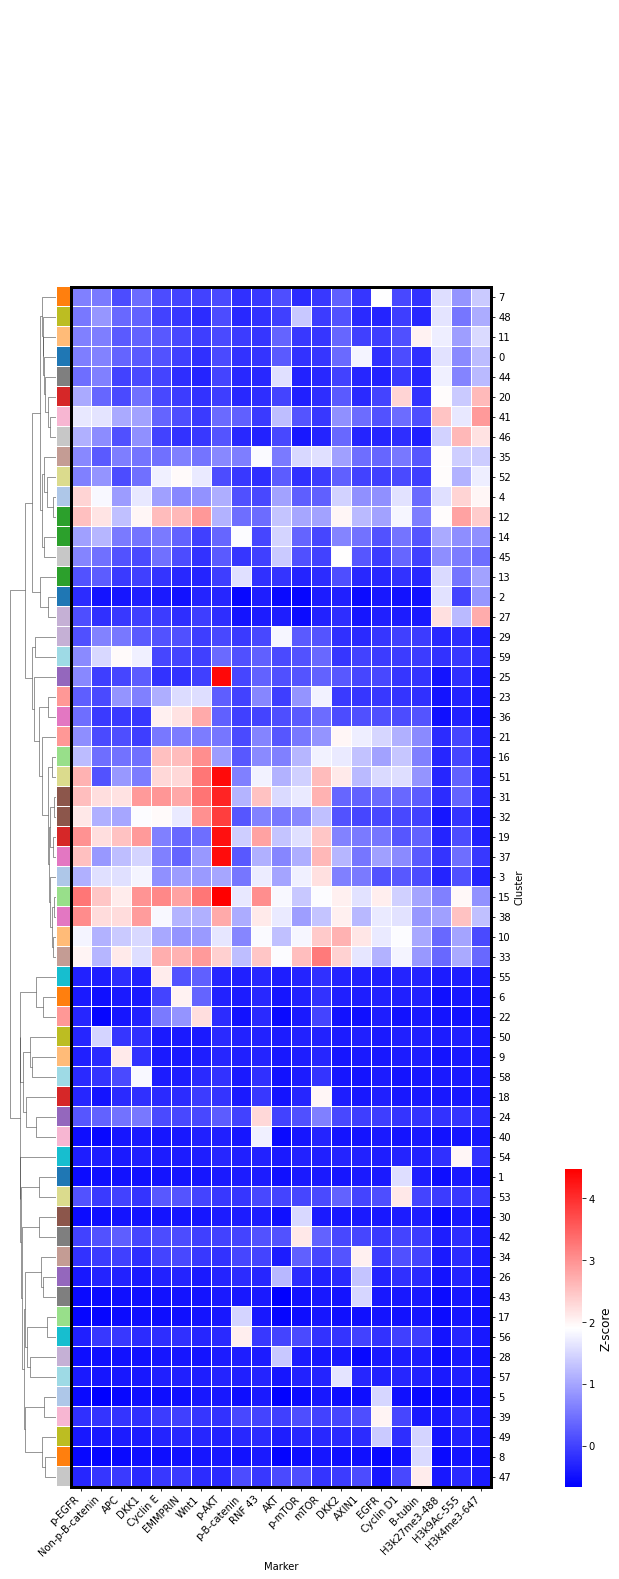

In [13]:
# Get linkage
d = sch.distance.pdist(df_per_label, metric='cosine')
L = sch.linkage(d, method="average")

# Get colormap
vals = np.linspace(0, 1, len(df_per_label))
my_cmap_row = plt.cm.tab20(vals)

# Clustermap and umap
labels = df_per_label.index.to_list()
my_cmap_dict = dict(zip(labels, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)
create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)
# create_umap(embeddings, parc_labels, my_cmap_row)

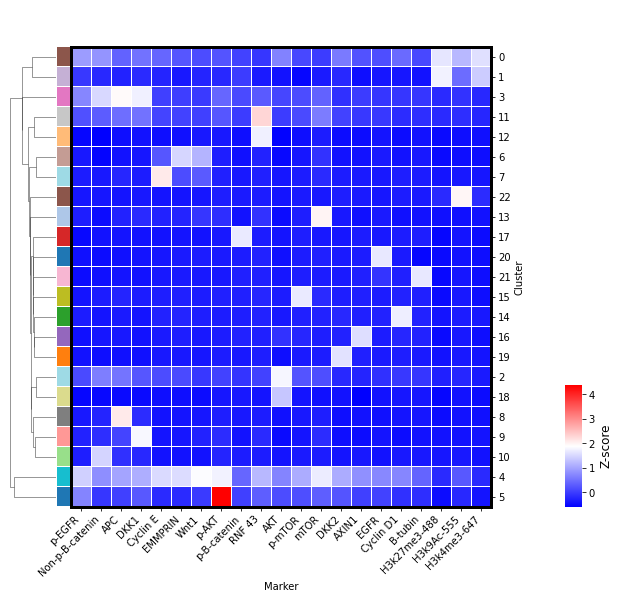

In [14]:
tol = 0.3

# Merge similar cluster
clusters = sch.fcluster(L, tol * d.max(), "distance") - 1
clusters_unique = np.unique(clusters)
n_clusters = len(np.unique(clusters))

# Clustermap and umap
label2cluster = dict(zip(labels, clusters))
result = defaultdict(int)
for k, v in zip(clusters, labels):
    result[k] = max(result[k], v)
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(result).map(my_cmap_dict)
clusters = np.array(list(map(label2cluster.get, labels)))
new_parc_labels = np.array(list(map(result.get, clusters)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Clustermap and umap with new colormap
vals = np.linspace(0, 1, n_clusters)
np.random.seed(0)
np.random.shuffle(vals)
my_cmap_row = plt.cm.tab20(vals)
my_cmap_dict = dict(zip(clusters_unique, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(my_cmap_dict)
new_parc_labels = np.array(list(map(label2cluster.get, labels)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Combined 
df_combined = pixels_bright_position.copy()
df_combined.label = df_combined.label.map(label2cluster.get)
df_combined = df_combined.groupby("label").mean()
labels = df_combined.index.to_list()

row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)

create_HM(df_combined, my_cmap, row_colors, scale_name)


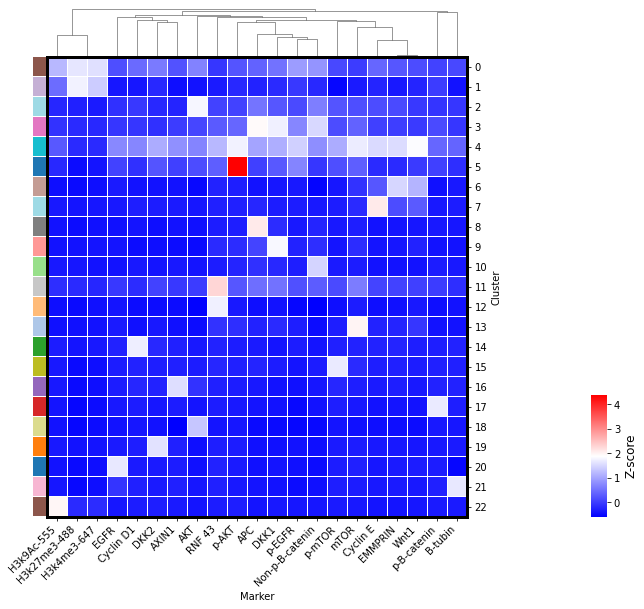

In [15]:
def create_HM_col(df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom']
    Ny,Nx = df_per_label.shape
    figWidth = (Nx*cellSizePixels/dpi)/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/marginHeight
    
    ax = sns.clustermap(df_per_label,
                        cmap=my_cmap,
                        linewidth=0.5,
                        row_cluster=False,
                        row_colors=[row_colors],
                        dendrogram_ratio=(0.0, 0.1),
                        figsize=(figWidth, figHeigh),
                        **kwargs
                        )
    ax.ax_heatmap.set_yticklabels(
        ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.ax_heatmap.set_xlabel('Marker')
    ax.ax_heatmap.set_ylabel('Cluster')
    
    # calculate the size of the heatmap axes
    axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                                  axWidth, axHeight])

    # resize dendrograms to match
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])
    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                         ax_row_orig_pos.width, axHeight])

    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))
    
    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

d2 = sch.distance.pdist(df_combined.T, metric='cosine')
L2 = sch.linkage(d2, method="average")
create_HM_col(df_combined, my_cmap, row_colors, scale_name, col_linkage=L2)


# Per cell stats

In [16]:
pixels_bright_position = pixels_bright_position.join(df[["Z", "X", "Y", "Id"]])
pixels_bright_position

,p-EGFR,Non-p-B-catenin,APC,DKK1,Cyclin E,EMMPRIN,Wnt1,p-AKT,p-B-catenin,RNF 43,...,Cyclin D1,B-tubin,H3k27me3-488,H3k9Ac-555,H3k4me3-647,label,Z,X,Y,Id
67,-0.798968,-0.979401,0.548499,-0.599020,-0.804101,-0.782601,-0.625489,-0.330911,-0.885905,-0.798822,...,-0.875301,-0.854162,-0.240800,-0.797298,-0.304369,18,1,0,91,2
92,-0.522576,-0.198244,-0.860623,-0.831301,-0.804101,-0.782601,-0.625489,0.151950,-0.885905,-0.798822,...,-0.875301,-0.854162,0.217293,-0.797298,-0.621903,5,1,0,116,2
98,-0.798968,0.494868,1.576928,-0.135266,-0.804101,-0.782601,-0.625489,-0.601084,-0.885905,-0.798822,...,-0.875301,-0.854162,-0.219848,-0.797298,-0.295032,9,1,0,122,2
100,-0.798968,-0.979401,2.393490,-0.831301,-0.804101,-0.428476,-0.625489,-0.601084,-0.885905,-0.798822,...,-0.875301,-0.854162,-0.342479,-0.797298,-0.370320,9,1,0,124,2
101,-0.798968,-0.979401,1.245149,-0.468932,-0.804101,-0.782601,-0.625489,-0.323183,-0.885905,-0.438437,...,-0.875301,-0.854162,-0.654865,-0.797298,-0.621903,9,1,0,125,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29355050,-0.798968,-0.979401,-0.860623,-0.075676,-0.804101,-0.782601,-0.431259,-0.601084,-0.885905,1.745752,...,-0.261326,-0.854162,-0.654865,-0.797298,-0.621903,40,19,1373,1879,42
29355051,-0.798968,-0.979401,-0.860623,0.349353,0.377843,1.151190,-0.479325,-0.601084,-0.885905,0.293292,...,0.411687,-0.854162,-0.654865,0.585722,-0.621903,5,19,1373,1880,42
29355052,-0.187623,-0.979401,-0.860623,-0.831301,0.245765,0.383806,1.044880,-0.601084,-0.885905,1.133821,...,-0.875301,-0.854162,-0.654865,-0.797298,-0.621903,57,19,1373,1881,42
29355054,-0.451842,-0.979401,-0.860623,-0.360972,-0.804101,1.461251,0.013661,-0.601084,-0.885905,0.753231,...,0.391864,-0.854162,-0.654865,-0.797298,-0.621903,6,19,1373,1883,42


In [17]:
df_count =  pixels_bright_position[['Z', 'Id', 'label']]
df_count.label = df_count.label.map(label2cluster)
df_count = df_count.groupby(['Z', 'Id', 'label']).size().reset_index(name='Count')

C:\Users\thu71\.conda\envs\ParcEnv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [18]:
df_count 

,Z,Id,label,Count
0,1,2,0,1
1,1,2,1,1107
2,1,2,6,146
3,1,2,7,19
4,1,2,8,91
...,...,...,...,...
20028,19,49,18,127
20029,19,49,19,23
20030,19,49,20,476
20031,19,49,21,630


## Pixel location visualization

First we add back the location and condition information in the pixel_bright dataframe

In [19]:
import matplotlib.patches as mpatches
from collections import Counter

def non_border_cell(cell_mask):
    labels = []
    row_max, col_max = cell_mask.shape
    props = measure.regionprops(cell_mask)
    for prop in props:
        if prop['bbox'][0] == 0 or prop['bbox'][1] == 0 or prop['bbox'][2] == row_max or prop['bbox'][3] == col_max:
            continue
        else:
            labels.append(int(prop['label']))
    return labels

def create_image_cluster(df, mask, label2cluster=None):
    # Create image from pixel location
    x_max, y_max = mask.shape

    x = df.X.tolist()
    y = df.Y.tolist()
    if label2cluster:
        values = df.label.map(label2cluster).tolist()
    else:
        values = np.array(df.label.tolist())
        
    img = np.zeros((x_max, y_max)) * np.nan
    img[x, y] = values
    return img, x, y, values


def get_bbx(label, mask):
    props = measure.regionprops_table(mask, properties=["label", "bbox"])
    df_prop = pd.DataFrame(props)
    return df_prop[df_prop.label == label].iloc[:, -4:].values[0] + np.array(
        [-2, -2, 2, 2]
    )

def fov_cluster(img, my_cmap, contours, contours_nuclei, cells, savepath=None):
    # Get random colormap
    my_cmap_pixel = plt.cm.colors.ListedColormap(my_cmap)

    # Show contour
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(img, cmap=my_cmap_pixel, interpolation="none", vmin=0, vmax=len(my_cmap)-1)
#     utils.plot_contours(contours, ax, cells=cells)
#     utils.plot_contours(contours_nuclei, ax, cells=cells)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False,
                   left=False, labelleft=False)
    ax.patch.set_facecolor("k")
    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    
def scatter_cell(cell_id, x, y, values, my_cmap, contours, contours_nuclei, savepath=None):
    my_camp_scatter = plt.cm.colors.ListedColormap(my_cmap)

    ymin, xmin, ymax, xmax = get_bbx(cell_id, mask)
    contours = contours[cell_id]
    contours_nuclei = contours_nuclei[cell_id]

    fig, ax = plt.subplots(figsize=(20, 20))
    size = int(max(ymax-ymin, xmax-xmin))
    size = 2*20*fig.dpi/size
    ax.scatter(y, x, s=size, c=values, cmap=my_camp_scatter, vmin=0, vmax=len(my_cmap)-1)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c="w")
    for contour_nuclei in contours_nuclei:
        ax.plot(contour_nuclei[:, 1], contour_nuclei[:, 0], linewidth=2, c="w")
        
    count = Counter(values)
    count_sorted = dict(count.most_common())
    # Color legend
    patches = [
        mpatches.Patch(color=my_cmap[i], label=i)
        for i in list(count_sorted.keys())[:15]
    ]
    ax.legend(
        handles=patches,
        bbox_to_anchor=(0, 0),
        loc="lower right",
        borderaxespad=0.0,
        fontsize=12,
    )

    ax.set(aspect="equal", xlim=[xmin, xmax], ylim=[ymin, ymax])
    ax.invert_yaxis()
    fig.set_facecolor("k")
    ax.axis("off")
    
    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
        plt.close(fig)
    
# Load contours
contours_all, contours_nuclei_all = utils.load_pickle(data_meta / "contours.pickle")

### One location 

In [ ]:
location =  36

masks = utils.get_masks(data_mask)
mask, mask_nuclei, _ = utils.qc_nuclei(masks[str(location)]["cyto"], masks[str(location)]["nuclei"])

cells = non_border_cell(mask)
print(cells)

In [ ]:
Z = '1'
df_subset = pixels_bright_position[pixels_bright_position.Z == 1]
img, _,_,_ = create_image_cluster(df_subset, mask, label2cluster)
# img, _, _, _ = create_image_cluster(df_subset, mask)

In [ ]:
fov_cluster(img, my_cmap_row, contours_all[str(location)], contours_nuclei_all[str(location)], cells,
            savepath = figure_dir / 'pixel_clustering_3D' / f'{Z}_all.png')

In [ ]:
%matplotlib inline
cell_id = cells[0]
_, x, y, values = create_image_cluster(df_subset[df_subset.Id == cell_id], mask, label2cluster)
scatter_cell(cell_id, x, y, values, my_cmap_row, contours_all[str(location)], contours_nuclei_all[str(location)], savepath=None)

### Loop all dataset 

In [20]:
Z_stacks = pixels_bright_position.Z.unique()


In [21]:
location =  36

masks = utils.get_masks(data_mask)
mask, mask_nuclei, _ = utils.qc_nuclei(masks[str(location)]["cyto"], masks[str(location)]["nuclei"])

In [22]:
for z in Z_stacks:
    df_subset = pixels_bright_position[pixels_bright_position.Z == z]
    img, _,_,_ = create_image_cluster(df_subset, mask, label2cluster)

    for i in np.unique(img[~np.isnan(img)]):
        binary = np.where(img==i, 1, 0)
        skimage.io.imsave(figure_dir / 'pixel_clustering_3D' / f'cluster{int(i)}_z_{z}.tiff', binary)


#     Pixeled fov image
#     fov_cluster(img, my_cmap_row, contours_all[str(location)], contours_nuclei_all[str(location)], cells, 
#             savepath = figure_dir / 'pixel_clustering_3D' / f'{z}_all.png')

#     for cell_id in cells:
#         _, x, y, values = create_image_cluster(df_subset[df_subset.Id == cell_id], mask, label2cluster)
#         scatter_cell(cell_id, 
#                      x, 
#                      y, 
#                      values, 
#                      my_cmap_row, 
#                      contours_all[str(location)], 
#                      contours_nuclei_all[str(location)], 
#                      savepath=figure_dir / 'cell_scatter_3D' / f'{z}_{cell_id}.png')

<ipython-input-22-b903d5f4ea1f>:7: UserWarning: Y:\coskun-lab\Thomas\Spatial signaling\dataset 4\figures\pixel_clustering_3D\cluster0_z_1.tiff is a low contrast image
  skimage.io.imsave(figure_dir / 'pixel_clustering_3D' / f'cluster{int(i)}_z_{z}.tiff', binary)
<ipython-input-22-b903d5f4ea1f>:7: UserWarning: Y:\coskun-lab\Thomas\Spatial signaling\dataset 4\figures\pixel_clustering_3D\cluster1_z_1.tiff is a low contrast image
  skimage.io.imsave(figure_dir / 'pixel_clustering_3D' / f'cluster{int(i)}_z_{z}.tiff', binary)
<ipython-input-22-b903d5f4ea1f>:7: UserWarning: Y:\coskun-lab\Thomas\Spatial signaling\dataset 4\figures\pixel_clustering_3D\cluster2_z_1.tiff is a low contrast image
  skimage.io.imsave(figure_dir / 'pixel_clustering_3D' / f'cluster{int(i)}_z_{z}.tiff', binary)
<ipython-input-22-b903d5f4ea1f>:7: UserWarning: Y:\coskun-lab\Thomas\Spatial signaling\dataset 4\figures\pixel_clustering_3D\cluster3_z_1.tiff is a low contrast image
  skimage.io.imsave(figure_dir / 'pixel_clus

# Umap

In [ ]:
n = 500
df_subset = pixels_bright_position.iloc[::n, :-5]
labels_subset = pixels_bright_position.iloc[::n, -5]

In [ ]:
import scipy
import umap

def show_umap(df_subset, labels_subset, label2cluster, my_cmap_row):
    
    sparse_mat = scipy.sparse.csr_matrix(df_subset.values)
    print('Umap embedding')
    embeddings = umap.UMAP().fit_transform(sparse_mat)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    X, Y = embeddings[:, 0], embeddings[:, 1]
    ax.scatter(X, Y, c=labels_subset, s=2, cmap='jet')
    ax.axis("off")
    plt.show()
    
    create_umap(embeddings, list(map(label2cluster.get, labels_subset)), my_cmap_row)


In [ ]:
show_umap(df_subset, labels_subset, label2cluster, my_cmap_row)